<a href="https://colab.research.google.com/github/MudassarAQazi/DL_Project_1_Leaf_Disease_Detection/blob/main/DL_Project_1_Leaf_Disease_Detection_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

## Observe TensorFlow speedup on GPU relative to CPU

This example constructs a typical convolutional neural network layer over a
random image and manually places the resulting ops on either the CPU or the GPU
to compare execution speed.

In [ ]:
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

In [ ]:
# !pip install pandas

In [ ]:
# !pip install seaborn

In [ ]:
import numpy as np
import pandas as pd
import pickle
import h5py
import cv2
import os
from os import listdir
import tensorflow as tf
from tensorflow import keras as k
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
# from keras.layers import LeakyRelu
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing import image
from keras_preprocessing.image import img_to_array
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter

# Example of loading an image with the Keras API
from keras_preprocessing.image import load_img
import seaborn as sn
from tensorflow.keras.models import load_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
default_image_size = tuple((256, 256))
image_size = 0
directory_root = "../content/drive/MyDrive/PlantVillage"
# directory_root = "Downloads\DL\PlantVillage"
width=256
height=256
depth=3

In [ ]:
# !pwd
print(directory_root)

../content/drive/MyDrive/PlantVillage


In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Pepper_bell_Bacterial_spot ...
[INFO] Processing Pepper_bell_healthy ...
[INFO] Processing Potato_Early_blight ...
[INFO] Processing Potato_healthy ...
[INFO] Processing Potato_Late_blight ...
[INFO] Processing Tomato_Target_Spot ...
[INFO] Processing Tomato_Tomato_mosaic_virus ...
[INFO] Processing Tomato_Tomato_YellowLeaf_Curl_Virus ...
[INFO] Image loading completed


In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [ ]:
print(label_binarizer.classes_)

['Pepper_bell_Bacterial_spot' 'Pepper_bell_healthy' 'Potato_Early_blight'
 'Potato_Late_blight' 'Potato_healthy' 'Tomato_Bacterial_spot'
 'Tomato_Early_blight' 'Tomato_Late_blight' 'Tomato_Leaf_Mold'
 'Tomato_Septoria_leaf_spot' 'Tomato_Spider_mites_Two_spotted_spider_mite'
 'Tomato_Target_Spot' 'Tomato_Tomato_YellowLeaf_Curl_Virus'
 'Tomato_Tomato_mosaic_virus' 'Tomato_healthy']


In [ ]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [ ]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [ ]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [ ]:
x_test.shape[0]

591

In [ ]:
y_test.shape[0]

591

In [ ]:
boom = np.argmax(y_test, axis = 1)

In [ ]:
boom = list(boom)

In [ ]:
val_keys = Counter(boom).keys() # equals to list(set(words))
val_boom = Counter(boom).values()

In [ ]:
val_keys = list(val_keys)

In [ ]:
val_boom = list(val_boom)

In [ ]:
val_boom

[38, 36, 51, 39, 31, 54, 38, 45, 30, 46, 40, 47, 27, 32, 37]

In [ ]:
Z = [x for _,x in sorted(zip(val_keys,val_boom))]

In [ ]:
Z

[46, 38, 31, 36, 27, 47, 37, 45, 54, 38, 40, 51, 32, 39, 30]

In [ ]:
classes = label_binarizer.classes_

In [ ]:
n_classes

15

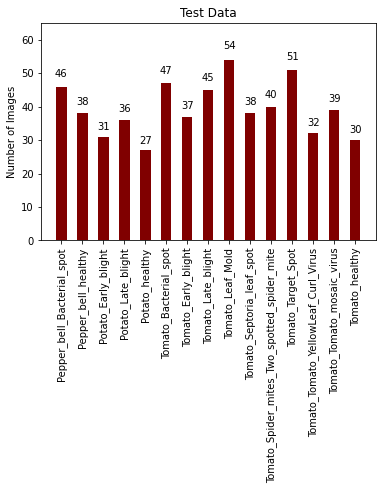

In [ ]:
fig, ax = plt.subplots()
rects1 = ax.bar(classes, Z, color ='maroon', width = 0.5)
ax.set_title('Test Data')
# ax.set_xticks(val_boom)
ax.set_xticklabels(classes)
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 90-degrees
ax.set_ylabel('Number of Images')

plt.ylim(top=65) 
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
plt.show()

In [ ]:
# load model
model = load_model('../content/drive/MyDrive/DL_Project_1_Leaf_Disease_Detection_Model_250_Epochs.h5')

In [ ]:
os.path.exists("../content/drive/MyDrive/pepperbell.jpg")

True

In [ ]:
# image for prediction
image_dir= "../content/drive/MyDrive/pepperbel.jpg"#"a.jpg"
im1 = load_img(image_dir)

im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)

In [ ]:
# prediction result for single image
result=model.predict(npp_image)
print(result)

1/1 [==============================] - 1s 862ms/step
[[1.0000000e+00 1.6565324e-11 4.6477740e-15 3.4836779e-23 5.6671945e-25
  3.4370536e-24 3.0381930e-12 5.1855013e-11 1.9012285e-18 5.1814617e-17
  2.6603498e-24 2.0924023e-28 1.1950573e-11 2.7961031e-19 1.0535327e-26]]


In [ ]:
# predicted name of the disease
itemindex = np.where(result==np.max(result))
print("probability:"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])

probability:1.0
Pepper_bell_Bacterial_spot


In [ ]:
x_test_result=model.predict(x_test)
print(x_test_result)

19/19 [==============================] - 484s 25s/step
[[4.36013991e-13 9.99928892e-01 7.66898633e-09 ... 1.72192996e-10
  1.80207792e-07 1.59666669e-07]
 [2.22128580e-14 9.35390681e-14 4.65236932e-10 ... 4.51276516e-11
  1.12193546e-10 4.12275353e-10]
 [6.06035555e-10 2.99542285e-06 5.55042590e-09 ... 1.82516613e-09
  2.00567342e-07 7.24336147e-01]
 ...
 [1.53319359e-15 9.86393338e-19 1.62618457e-15 ... 1.00000000e+00
  1.07791902e-13 2.14708267e-16]
 [2.07235894e-06 4.28697291e-08 7.42312115e-12 ... 1.51947575e-07
  1.99507494e-10 1.15691701e-12]
 [5.54820387e-15 1.90183977e-16 7.23654414e-10 ... 5.65614883e-13
  1.56761438e-14 1.96094917e-13]]


In [ ]:
x_test_result.shape

(591, 15)

In [ ]:
y_test.shape

(591, 15)

In [ ]:
labels = tf.argmax(y_test,1)

In [ ]:
labels.shape

TensorShape([591])

In [ ]:
predictions = tf.argmax(result,1)

In [ ]:
predictions.shape

TensorShape([1])

In [ ]:
cm = tf.math.confusion_matrix(labels = tf.argmax(y_test,1), predictions = tf.argmax(x_test_result,1))

In [ ]:
cm = cm.numpy()

In [ ]:
cm

array([[44,  0,  0,  0,  0,  0,  1,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0, 37,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 31,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  2, 28,  0,  0,  0,  3,  0,  0,  1,  0,  0,  0,  1],
       [ 0,  0,  0,  0, 27,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 44,  0,  0,  1,  0,  0,  0,  2,  0,  0],
       [ 1,  1,  0,  0,  0,  0, 31,  3,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  2,  4, 33,  0,  0,  1,  0,  0,  0,  4],
       [ 0,  0,  0,  0,  0,  0,  0,  1, 52,  0,  0,  0,  1,  0,  0],
       [ 1,  1,  0,  0,  0,  0,  1,  1,  9, 23,  1,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  4,  0, 36,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  1,  0,  3,  0,  4,  0, 16, 17,  0,  1,  8],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 32,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 39,  0],
       [ 0,  0,  0,  0,  0,  0,  0

In [ ]:
classes

array(['Pepper_bell_Bacterial_spot', 'Pepper_bell_healthy',
       'Potato_Early_blight', 'Potato_Late_blight', 'Potato_healthy',
       'Tomato_Bacterial_spot', 'Tomato_Early_blight',
       'Tomato_Late_blight', 'Tomato_Leaf_Mold',
       'Tomato_Septoria_leaf_spot',
       'Tomato_Spider_mites_Two_spotted_spider_mite',
       'Tomato_Target_Spot', 'Tomato_Tomato_YellowLeaf_Curl_Virus',
       'Tomato_Tomato_mosaic_virus', 'Tomato_healthy'], dtype='<U43')

In [ ]:
df_cm = pd.DataFrame(cm, classes, classes)

In [ ]:
df_cm

,Pepper_bell_Bacterial_spot,Pepper_bell_healthy,Potato_Early_blight,Potato_Late_blight,Potato_healthy,Tomato_Bacterial_spot,Tomato_Early_blight,Tomato_Late_blight,Tomato_Leaf_Mold,Tomato_Septoria_leaf_spot,Tomato_Spider_mites_Two_spotted_spider_mite,Tomato_Target_Spot,Tomato_Tomato_YellowLeaf_Curl_Virus,Tomato_Tomato_mosaic_virus,Tomato_healthy
Pepper_bell_Bacterial_spot,44,0,0,0,0,0,1,0,0,1,0,0,0,0,0
Pepper_bell_healthy,0,37,0,0,0,0,0,1,0,0,0,0,0,0,0
Potato_Early_blight,0,0,31,0,0,0,0,0,0,0,0,0,0,0,0
Potato_Late_blight,1,0,2,28,0,0,0,3,0,0,1,0,0,0,1
Potato_healthy,0,0,0,0,27,0,0,0,0,0,0,0,0,0,0
Tomato_Bacterial_spot,0,0,0,0,0,44,0,0,1,0,0,0,2,0,0
Tomato_Early_blight,1,1,0,0,0,0,31,3,0,0,1,0,0,0,0
Tomato_Late_blight,0,0,1,0,0,2,4,33,0,0,1,0,0,0,4
Tomato_Leaf_Mold,0,0,0,0,0,0,0,1,52,0,0,0,1,0,0
Tomato_Septoria_leaf_spot,1,1,0,0,0,0,1,1,9,23,1,0,1,0,0


In [ ]:
plt.figure(figsize = (10,7))

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

Text(32.093749999999986, 0.5, 'True Classes')

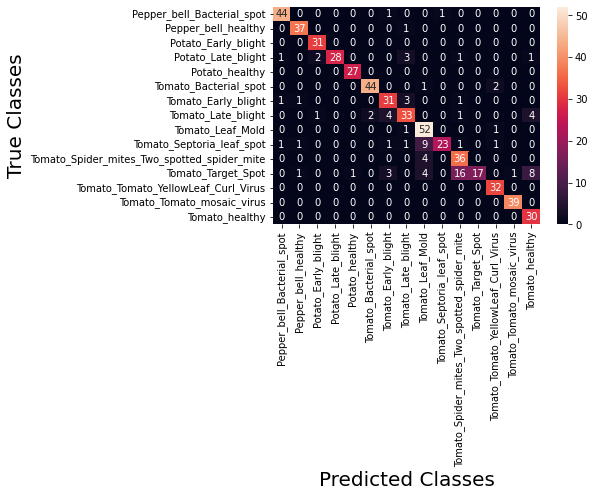

In [ ]:
confusion_matrics = sn.heatmap(df_cm, annot  =True)
confusion_matrics.set_xlabel('Predicted Classes', fontsize=20)
confusion_matrics.set_ylabel('True Classes', fontsize=20)

# **End of Code**